In [1]:
# Load required libraries

# Load required libraries

import pandas as pd
import numpy as np
import sklearn as sk
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

import re
import random

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import Dropout
from torch.nn import Linear
from tqdm import tqdm
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from transformers import DistilBertConfig
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



from sklearn.metrics.pairwise import cosine_similarity

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [22]:
import pandas as pd
import pandas as pd
from sklearn.utils import resample
df_1 = pd.read_csv('/kaggle/input/equal-sample/equal_sample_english_songs_50000.csv')

In [23]:

# Sample 10000 random records from the dataset
df_sample = resample(df_1, n_samples=50000, random_state=42, replace=False)

# Get the counts of each tag/category
tag_counts = df_sample['tag'].value_counts()

print(tag_counts)

tag
rb         10000
country    10000
pop        10000
rock       10000
rap        10000
Name: count, dtype: int64


In [24]:
# Assume 'lyrics' is the column in your dataframe `df` containing the song lyrics
df_sample['word_count'] = df_sample['lyrics'].str.split().str.len()
df = df_sample[(df_sample['views'] >= 10000) & (df_sample["word_count"] >= 150)]

# Cleaning

In [48]:
# Function to clean text
def clean_text(text):
    # Remove the text in brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Replace line breaks and multiple whitespaces with a single space
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespaces
    text = text.strip()
    return text

# Apply the cleaning function to your text column
df['cleaned_text'] = df['lyrics'].apply(clean_text)

print(df['cleaned_text'])

26497    True story, ain't no lyin' A wise man can play...
38340    I know what it is to be broken and be bold Tel...
29226    Shout out to Saweetie It's your girl Jamie こんに...
29600    I put my heart in my lyrics I gave it all I co...
44233    It's gone alright Well soak it in I mean this ...
                               ...                        
16198    I remember dancing in the pouring rain Calling...
41523    Betray The Avalon is always beside me And I'm ...
22662    Yeah, yeah, Tomorrow I might just get that mot...
2695     You were made to shine under Southern stars Pu...
41434    Broken bottles in the hotel lobby Seems to me ...
Name: cleaned_text, Length: 1976, dtype: object


/tmp/ipykernel_47/2469178452.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['lyrics'].apply(clean_text)


In [49]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import torch

In [50]:
# Display the dimensions of the DataFrame
print(df.shape)

# Calculate the count of each value in the "Trainings-Labels" column
label_counts = df['tag'].value_counts()

# Print the label counts
print(label_counts)

(1976, 14)
tag
rb         579
rap        543
rock       368
country    279
pop        207
Name: count, dtype: int64


In [27]:
label_mapping = {'pop': 0, 'rap': 1, 'rock': 2, 'rb': 3, "country": 4}

lyrics_list = df['lyrics'].tolist()
tag_list = df['tag'].tolist()

numeric_labels = torch.tensor([label_mapping[label] for label in tag_list])
numeric_labels

tensor([1, 3, 1,  ..., 1, 4, 2])

In [28]:
label_counts = pd.Series(numeric_labels).value_counts()
print(label_counts)

3    579
1    543
2    368
4    279
0    207
Name: count, dtype: int64


## New Preparation

In [51]:
# Mapping labels to numbers
label_mapping = {'pop': 0, 'rap': 1, 'rock': 2, 'rb': 3, "country": 4}
df['numeric_labels'] = df['tag'].map(label_mapping)

# Train/Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['numeric_labels'])

# Convert train and test data to lists
train_lyrics = train_df['cleaned_text'].tolist()
train_labels = torch.tensor(train_df['numeric_labels'].tolist())

test_lyrics = test_df['cleaned_text'].tolist()
test_labels = torch.tensor(test_df['numeric_labels'].tolist())

# Tokenizer and Model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))


/tmp/ipykernel_47/679280600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['numeric_labels'] = df['tag'].map(label_mapping)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unca

In [52]:
class SongsDataset(Dataset):
    def __init__(self, songs, labels, tokenizer):
        self.songs = songs
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        song = str(self.songs[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            song,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [53]:
# Create datasets
train_dataset = SongsDataset(train_lyrics, train_labels, tokenizer)
test_dataset = SongsDataset(test_lyrics, test_labels, tokenizer)

# Data loaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modell Training

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 3
learning_rate = 1e-5
warmup_steps = 200

In [ ]:
import matplotlib.pyplot as plt

# Assuming num_epochs is defined
# Initialize a list to hold the average training loss for each epoch
train_loss_per_epoch = []

# Training loop
print("Starting Training")
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    total_train_loss = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = nn.CrossEntropyLoss()(logits, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    # Calculate average loss for this epoch and append to the list
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss}")
    train_loss_per_epoch.append(avg_train_loss)

# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_loss_per_epoch, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.legend()
plt.grid(True)
plt.show()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training
Epoch 1/3


  0%|          | 0/99 [00:00<?, ?it/s]/tmp/ipykernel_47/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)
100%|██████████| 99/99 [01:03<00:00,  1.56it/s]


Train Loss: 1.5649010701612993
Epoch 2/3


 55%|█████▍    | 54/99 [00:34<00:28,  1.59it/s]

# Hyperparameter Tuning

In [ ]:
import matplotlib.pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

# Define the parameters to tune and their possible values
learning_rates = [1e-5, 1e-6]
num_epochs_values = [10, 30]

# Initialize a dictionary to hold the average training loss for each parameter combination
train_loss_per_params = {}


# Initialize a dictionary to hold the test accuracy for each parameter combination
test_accuracy_per_params = {}

# Training loop
print("Starting Training")

for learning_rate in learning_rates:
    for num_epochs in num_epochs_values:
        print(f"Training with learning_rate={learning_rate} and num_epochs={num_epochs}")

        # Reinitialize the model for each combination of hyperparameters
        model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))
        model.to(device)
        model.train()

        optimizer = AdamW(model.parameters(), lr=learning_rate)
        total_steps = len(train_dataloader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

        train_loss_per_epoch = []

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            total_train_loss = 0

            for batch in tqdm(train_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = nn.CrossEntropyLoss()(logits, labels)
                total_train_loss += loss.item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                optimizer.step()
                scheduler.step()

            # Calculate average loss for this epoch and append to the list
            avg_train_loss = total_train_loss / len(train_dataloader)
            print(f"Train Loss: {avg_train_loss}")
            train_loss_per_epoch.append(avg_train_loss)

        # Store the average training loss for this parameter combination
        train_loss_per_params[(learning_rate, num_epochs)] = train_loss_per_epoch
        
        
        
                # Evaluate on test data
        model.eval()
        total_correct = 0
        total = 0
        correct_count= 0
        incorrect_count = 0

        with torch.no_grad():
            for batch in test_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                # Get the predictions
                preds = torch.argmax(logits, dim=1)

                # Update total and correct counts
                total += labels.size(0)
                total_correct += (preds == labels).sum().item()
                        # Update counters
                correct_count += (preds == labels).sum().item()
                incorrect_count += (preds != labels).sum().item()

        # Calculate accuracy
        accuracy = total_correct / total
        print(f"Test Accuracy: {accuracy}")
        print(f'Correct Predictions: {correct_count}')
        print(f'Incorrect Predictions: {incorrect_count}')
        print(f'Accuracy: {accuracy}')
        test_accuracy_per_params[(learning_rate, num_epochs)] = accuracy

# Output the test accuracies for each parameter combination
for params, accuracy in test_accuracy_per_params.items():
    print(f"Learning Rate: {params[0]}, Num Epochs: {params[1]}, Test Accuracy: {accuracy}")

# Plotting the training loss
for params, train_loss_per_epoch in train_loss_per_params.items():
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), train_loss_per_epoch, label=f'Training Loss for lr={params[0]}, epochs={params[1]}')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

/tmp/ipykernel_47/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


Accuracy: 0.6212121212121212
F1 Score: 0.6329664795494235


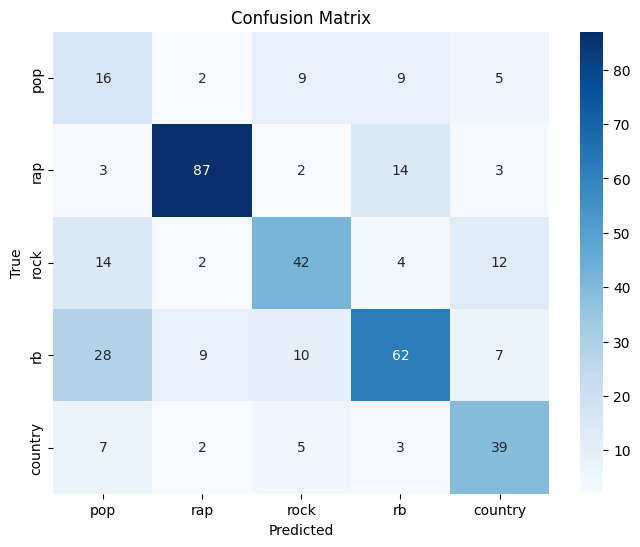

Classification Report:
              precision    recall  f1-score   support

         pop       0.24      0.39      0.29        41
         rap       0.85      0.80      0.82       109
        rock       0.62      0.57      0.59        74
          rb       0.67      0.53      0.60       116
     country       0.59      0.70      0.64        56

    accuracy                           0.62       396
   macro avg       0.59      0.60      0.59       396
weighted avg       0.66      0.62      0.63       396



In [47]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Prepare the model for evaluation
model.eval()
predictions = []
true_labels = []

# Disable gradient calculations
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

# Generate and visualize the confusion matrix
cm = confusion_matrix(true_labels, predictions)
label_names = list(label_mapping.keys())  # Replace with your label names if different
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_names))


In [ ]:
torch.save(model, 'BERT_Finetuned_Classification.pth')

In [109]:
#model = torch.load('/kaggle/input/modell/llm_model(1).pth')
#model.to('cuda')

# Evaluation of Final Test Data

In [110]:
df_finaltest = pd.read_csv('/kaggle/input/final-test/final_test_english_songs_10000.csv')


# Sample 10000 random records from the dataset
df_finaltest = resample(df_finaltest, n_samples=300, random_state=42, replace=False)

# Get the counts of each tag/category
tag_counts = df_finaltest['tag'].value_counts()

print(tag_counts)

tag
pop        128
rap         84
rock        68
rb          13
country      7
Name: count, dtype: int64


In [93]:
external_lyrics_list = df_finaltest['lyrics'].tolist()
external_tag_list = df_finaltest['tag'].tolist()

external_numeric_labels = torch.tensor([label_mapping[label] for label in external_tag_list])

# Create an external dataset
external_dataset = SongsDataset(external_lyrics_list, external_numeric_labels, tokenizer)

# Create an external data loader
external_dataloader = DataLoader(external_dataset, batch_size=16, shuffle=False)

# Evaluation for the external dataset
model.eval()
total_external_loss = 0
external_predictions = []
external_true_labels = []

for batch in tqdm(external_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    loss = nn.CrossEntropyLoss()(logits, labels)
    total_external_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    external_predictions.extend(np.argmax(logits, axis=1))
    external_true_labels.extend(label_ids)

avg_external_loss = total_external_loss / len(external_dataloader)
print(f"External Dataset Evaluation Loss: {avg_external_loss}")

external_accuracy = accuracy_score(external_true_labels, external_predictions)
external_f1 = f1_score(external_true_labels, external_predictions, average='weighted')

print(f"External Dataset Accuracy: {external_accuracy}")
print(f"External Dataset F1 Score: {external_f1}")

  0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_47/257860738.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)
100%|██████████| 19/19 [00:05<00:00,  3.38it/s]

External Dataset Evaluation Loss: 3.6467020009693347
External Dataset Accuracy: 0.4766666666666667
External Dataset F1 Score: 0.5041887934428576


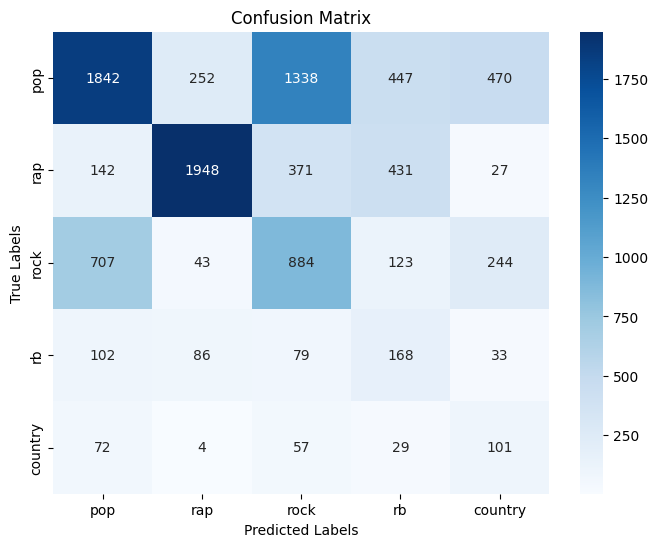

In [37]:
# Calculate the Confusion Matrix
confusion_mat = confusion_matrix(external_true_labels, external_predictions, labels=np.unique(external_true_labels))

# Labels for the axes labels
label_names = list(label_mapping.keys())

# Convert the Confusion Matrix to a Pandas DataFrame
cm_df = pd.DataFrame(confusion_mat, index=label_names, columns=label_names)

# Plot of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()